# 악성사이트 탐지 머신러닝 모델 개발 (1)

### 목표
 * 웹 페이지에서 Feature 크롤링 연습
 * AI모델을 통해 악성사이트 여부를 판별

### 데이터
* Feature_Website.xlsx : 웹 크롤링 데이터셋
    - html_code : 크롤링을 활용해 수집한 HTML Code 원본
    - repu : 악성사이트 여부 (malicious : 악성사이트, benign : 정상사이트)
<br>
---

In [2]:
import pandas as pd
import numpy as np
import openpyxl

from bs4 import BeautifulSoup
# import requests

## 1> 데이터 확인

* HTML Code를 활용해 Feature를 생성

In [3]:
df = pd.read_excel('data/Feature_Website_0307.xlsx', engine='openpyxl')
df.head()

,html_code,repu
0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang=...,malicious
1,\n\t\n\n\n\t\n\n\t\n\n\n\t\n\n\n\t\n\n\t\n\t\t...,malicious
2,"<!DOCTYPE html>\n<html lang=""en"">\n <head>\...",malicious
3,"<!DOCTYPE html><html lang=""en""><head><style da...",malicious
4,<!DOCTYPE html>\n\n\n \n \n \n \n ...,malicious


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   html_code  40 non-null     object
 1   repu       40 non-null     object
dtypes: object(2)
memory usage: 768.0+ bytes


---

## 2> Feature Engineering
* 주어진 데이터로만 모델링 하는 경우보다는 추가로 수집 또는 생성해야 하는 경우가 많음
* 정상/악성 사이트 HTML 데이터에서 BeatifulSoup을 활용해 필요한 Feature 추출

### 2-1> head 내 title 태그 길이 계산

In [5]:
soup0 = BeautifulSoup(df['html_code'][0], features='html.parser')
print(soup0)

<!DOCTYPE html>

<!--[if lt IE 7]> <html lang="en-us" class="a-no-js a-lt-ie9 a-lt-ie8 a-lt-ie7"> <![endif]-->
<!--[if IE 7]>    <html lang="en-us" class="a-no-js a-lt-ie9 a-lt-ie8"> <![endif]-->
<!--[if IE 8]>    <html lang="en-us" class="a-no-js a-lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!-->
<html class="a-no-js" lang="en-us"><!--<![endif]--><head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<title dir="ltr">Amazon.com</title>
<meta content="width=device-width" name="viewport"/>
<link href="https://images-na.ssl-images-amazon.com/images/G/01/AUIClients/AmazonUI-3c913031596ca78a3768f4e934b1cc02ce238101.secure.min._V1_.css" rel="stylesheet"/>
<script>

if (true === true) {
    var ue_t0 = (+ new Date()),
        ue_csm = window,
        ue = { t0: ue_t0, d: function() { return (+new Date() - ue_t0); } },
        ue_furl = "fls-na.amazon.com",
        ue_mid = "ATVPDKIKX0DER"

In [6]:
soup0.body.h4

<h4>Enter the characters you see below</h4>

In [7]:
# <title> 태그 출력
print("title :", soup0.head.title)

# <title> 태그 길이 출력
print("title 길이 :", len(str(soup0.head.title.getText())))

title : <title dir="ltr">Amazon.com</title>
title 길이 : 10


In [8]:
def title_len(html_code):
    soup = BeautifulSoup(html_code, features='html.parser')

    if (soup.head is not None) and (soup.head.title is not None): # head와 title 존재 여부 확인
        head_title = soup.head.title.getText()
        return len(head_title)
    
    return 0

In [9]:
df['head_title_len'] = df['html_code'].apply(title_len)
df.head(2)

,html_code,repu,head_title_len
0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang=...,malicious,10
1,\n\t\n\n\n\t\n\n\t\n\n\n\t\n\n\n\t\n\n\t\n\t\t...,malicious,5


### 2-2> \<script>~\</script> 태그 길이 계산

In [10]:
def script_len(html_code):
    soup = BeautifulSoup(html_code, features='html.parser')
    scripts = list(soup.find_all('script')) # 모든 script 태그
    len_scr = [len(str(scr)) for scr in scripts if scr is not None] # script 태그들의 각 길이, str(scr): bs4.element.Tag -> str
    
    return sum(len_scr)

In [11]:
df['script_len'] = df['html_code'].apply(script_len)
df.head(2)

,html_code,repu,head_title_len,script_len
0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang=...,malicious,10,1127
1,\n\t\n\n\n\t\n\n\t\n\n\n\t\n\n\n\t\n\n\t\n\t\t...,malicious,5,993


### 2-3> html 내 공백 수 계산

In [12]:
def html_whitespaces(html_code):
    soup = BeautifulSoup(html_code, features='html.parser')
    htmls = [str(x) for x in soup.find_all('html') if x is not None]
    spaces = [ht.count(' ') for ht in htmls]
    
    return sum(spaces)

In [13]:
df['html_whitespaces_count'] = df['html_code'].apply(html_whitespaces)
df.head(2)

,html_code,repu,head_title_len,script_len,html_whitespaces_count
0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang=...,malicious,10,1127,471
1,\n\t\n\n\n\t\n\n\t\n\n\n\t\n\n\n\t\n\n\t\n\t\t...,malicious,5,993,1318


### 2-4> body 길이 계산

In [14]:
def body_len(html_code):
    soup = BeautifulSoup(html_code, features='html.parser')

    if soup.body is not None:
        return len(soup.body.getText())
    
    return 0

In [15]:
df['body_len'] = df['html_code'].apply(body_len)
df.head(2)

,html_code,repu,head_title_len,script_len,html_whitespaces_count,body_len
0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang=...,malicious,10,1127,471,402
1,\n\t\n\n\n\t\n\n\t\n\n\n\t\n\n\n\t\n\n\t\n\t\t...,malicious,5,993,1318,1041


### 2-5> script 내 href, src 속성을 가진 태그수
* href, src 가 하이퍼링크로 연결되기 때문

In [16]:
# find: 찾는 문자의 인덱스 반환, 없으면 -1
# 전체 갯수를 새기 위해 find 대신 count 사용

def src_href_count(html_code):
    soup = BeautifulSoup(html_code, features='html.parser')
    if soup.body is None:
         return 0
    
    bodys = str(soup.body)
    src_count = bodys.count('src')
    href_count = bodys.count('href')

    return src_count + href_count

In [17]:
df['src_href_count'] = df['html_code'].apply(src_href_count)
df.head(2)

,html_code,repu,head_title_len,script_len,html_whitespaces_count,body_len,src_href_count
0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang=...,malicious,10,1127,471,402,7
1,\n\t\n\n\n\t\n\n\t\n\n\n\t\n\n\n\t\n\n\t\n\t\t...,malicious,5,993,1318,1041,35


### 2-6> download 속성을 가진 태그 수
* 악성 파일 다운로드를 유도할 수 있기 때문

In [18]:
def download_count(html_code):
    soup = BeautifulSoup(html_code, features='html.parser')
    if soup.body is None:
         return 0
    
    bodys = str(soup.body)
    dl_count = bodys.count('download')

    return dl_count

In [19]:
df['download_count'] = df['html_code'].apply(download_count)
df.head(2)

,html_code,repu,head_title_len,script_len,html_whitespaces_count,body_len,src_href_count,download_count
0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang=...,malicious,10,1127,471,402,7,0
1,\n\t\n\n\n\t\n\n\t\n\n\n\t\n\n\n\t\n\n\t\n\t\t...,malicious,5,993,1318,1041,35,0


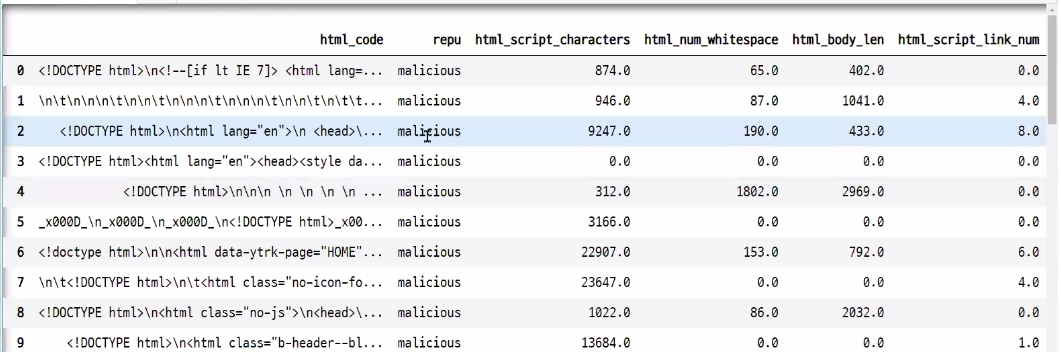

## 3> 모델링
* 데이터 수가 적기 때문에 큰 의미가 없음
* part2에서 다시 진행

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   html_code               40 non-null     object
 1   repu                    40 non-null     object
 2   head_title_len          40 non-null     int64 
 3   script_len              40 non-null     int64 
 4   html_whitespaces_count  40 non-null     int64 
 5   body_len                40 non-null     int64 
 6   src_href_count          40 non-null     int64 
 7   download_count          40 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 2.6+ KB


In [21]:
from sklearn.model_selection import train_test_split

In [23]:
target = 'repu'

x = df.drop(columns=['html_code', 'repu'], axis=1)
y = df.loc[:, target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
param_rf = {'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7]}

model_rf = GridSearchCV(RandomForestClassifier(),
                        param_grid=param_rf,
                        cv=5,
                        scoring='accuracy')

model_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [25]:
y_pred_rf = model_rf.predict(x_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[2 2]
 [1 3]]
              precision    recall  f1-score   support

      benign       0.67      0.50      0.57         4
   malicious       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8

